# GEOtiled Demo: A Scalable Workflow for Generating Large Datasets of High-Resolution Terrain Parameters

The GEOtiled workflow is comprised of three stages: 
1. Reproject and partition a Digital Elevation Model (DEM) into tiles, each with a buffer region
2. Compute the terrain parameters for each individual tile concurrently
3. Mosaic each parameter's tiles together

<p style="text-align:center">
    <img src="demo_images/workflow.png" width="500"/>
</p>
<p style="text-align:center">
    <b>Figure 1. </b>GEOtiled Workflow
</p>
    
Terrain parameters are computed using DEMs from [USGS 3DEP Products](https://www.usgs.gov/3d-elevation-program/about-3dep-products-services) to compute 3 topographic parameters: aspect, hillshade, and slope. By default, this demo uses 3DEP products covering the entirety of the US state of Tennessee at a 30m resolution.

If you would like to work with a different region of data, go to the [USGS Data Download Application](https://apps.nationalmap.gov/downloader/#/elevation) and use the map to look for available DEM data. Data should be downloaded using the TXT button located under the *Products* tab, and the text file should be stored in your working directory.

**IMPORTANT NOTE: Larger regions or higher resolutions will significantly increase the size of the data and the time to compute it.** 

## Environment Setup

The first cell below imports required libraries to run the notebook.

In [1]:
from pathlib import Path
import glob
import os
import shutil
import multiprocessing
import geotiled

geotiled.gdal.UseExceptions() # Used to silence a deprecation warning. 

/home/exouser/GEOtiled/geotiled/src/geotiled.py:1: SyntaxWarning: invalid escape sequence '\ '
  '''


### Settings

In the following cell you may specify variables such as what data to download, the number of intermediary tiles to use for computation, and the file paths where data will be stored. Comments for what each variable is for is included.

**Important Notes**
* For DEM download, three different methods are available: from a text file with a list of USGS download links, based off a shape file, or a specified latitude and longitude box
  * A text file from the USGS page should be stored in the working directory or child directory
  * Shape files are available for all US states and Washington DC. For the shapefile variable, specify the state abbreviation to use the correlating shapefile (e.g. TN for Tennessee)
  * A bounding box can be specified using the following syntax: {"xmin": val,"ymin": val,"xmax": val,"ymax": val}. X values correlate to longitude and Y values correlate to latitude

In [2]:
download_list = './download_urls.txt'                                    # Path to list of URLs for DEM download
shape_file = 'TN'                                                        # State shape file to use for DEM download
bounding_box = {"xmin": -90.4,"ymin": 34.8,"xmax": -81.55,"ymax": 36.8}  # Bounding box to use for DEM download
n_tiles = 16                                                             # Number of tiles to split the DEM mosaic into

root_folder = './computed_data/'                                         # Root folder where GEOtiled data will be stored
dem_directory = 'dem_tiles'                                              # Folder where downloaded DEM tiles will be stored
rep_directory = 'elevation_tiles'                                        # Folder where reprojected, split DEM tiles will be stored

dem_mosaic = 'mosaic'                                                    # Name of the mosaicked DEM file
rep_mosaic = 'elevation'                                                 # Name of the reprojected DEM file

### Create Directories

The following cell creates needed file paths after specifying the path and file names above.

In [3]:
# Root, DEM, and reprojected file paths creation
tiles_folder = os.path.join(root_folder, dem_directory)
elevation_tiles = os.path.join(root_folder, rep_directory)
Path(root_folder).mkdir(parents=True, exist_ok=True)
Path(tiles_folder).mkdir(parents=True, exist_ok=True)
Path(elevation_tiles).mkdir(parents=True, exist_ok=True)

# Update mosaic and reprojected DEM file paths
dem_mosaic = os.path.join(root_folder, dem_mosaic + '.tif')
rep_mosaic = os.path.join(root_folder, rep_mosaic + '.tif')

# Update shape_file variable to have path to correlating shape file
shape_file = glob.glob('../shape_files/' + shape_file + '/*.shp')

# Terrain parameter file paths creation
aspect_tiles = os.path.join(root_folder, 'aspect_tiles')
hillshading_tiles = os.path.join(root_folder, 'hillshading_tiles')
slope_tiles = os.path.join(root_folder, 'slope_tiles')
Path(aspect_tiles).mkdir(parents=True, exist_ok=True)
Path(hillshading_tiles).mkdir(parents=True, exist_ok=True)
Path(slope_tiles).mkdir(parents=True, exist_ok=True)

## Pre-processing of the DEM

### Fetch Data

`fetch_dem()` pulls DEM data directly from the USGS webpage with a specified shape file or bounding box and a desired dataset. It will return a text file with the download URLs which can be saved or immediately downloaded from. **Note that if both a shape file and bounding box are given, the shape file will take precedent.**

`download_files()` downloads the DEMs from a supplied text file with URLs or a Python list of strings containing the URLs. If you would like to use your own text file to download DEMs, skip `fetch_dem()` and only run this function.

In [4]:
# Create a text file with download URLs from a shape file
geotiled.fetch_dem(shapeFile=shape_file[0],txtPath=download_list, dataset="National Elevation Dataset (NED) 1 arc-second Current")

# Download files from the created text file
geotiled.download_files(download_list, tiles_folder)

./download_urls.txt


Downloading: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1.72G/1.72G [00:15<00:00, 115MB/s]

### Mosaic and Reproject DEMs

`build_mosaic` creates a mosaic from a list of GeoTIFF files.

`reproject` reprojects a specified GeoTIFF raster dataset from its original coordinate system to a new specified projection. DEMs from USGS are projected using the Global Coordinate System (GCS) by default.

In [5]:
# Variable storing all DEM tiles into a list
raster_list = glob.glob(tiles_folder + '/*')

# Build mosaic from DEMs
geotiled.build_mosaic(raster_list, dem_mosaic)

# Reproject the mosaic to Projected Coordinate System (PCS) EPSG:9822 which is the Albers Conic Equal Area projection 
geotiled.reproject(dem_mosaic, rep_mosaic, 'EPSG:9822')

# Cleanup: delete downloaded DEM tiles, vertex file used for mosaic, and mosaic file
shutil.rmtree(tiles_folder)
os.remove('./merged.vrt')
os.remove(dem_mosaic)

0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40..

## Compute Parameters with GEOtiled

`crop_into_tiles()` splits a GeoTIFF file into a specified number of tiles.

`compute_geotiled()` concurrently computes terrain parameters slope, aspect, and hillshading for all provided elevation model files.

`build_mosaic_filtered()` is similar to `build_mosaic()` but includes extra logic to handle averaging of buffer regions made from cropping the mosaic.

In [6]:
# Crop reprojected mosaic into specified number of intermediary elevation tiles
geotiled.crop_into_tiles(rep_mosaic, elevation_tiles, n_tiles)

.50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90.

In [8]:
# Put intermediary elevation tiles into a list
#elev_tile_list = glob.glob(elevation_tiles + '/*.tif')

# Run GEOtiled to compute all terrain parameters for each tile
pool = multiprocessing.Pool(processes=n_tiles) 
pool.map(geotiled.compute_geotiled, sorted(glob.glob(elevation_tiles + '/*.tif')))

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [9]:
# Build the mosaic for each of the terrain parameters
geotiled.build_mosaic_filtered(sorted(glob.glob(aspect_tiles + '/*.tif')), os.path.join(root_folder, 'aspect.tif'))
geotiled.build_mosaic_filtered(sorted(glob.glob(hillshading_tiles + '/*.tif')), os.path.join(root_folder,'hillshading.tif'))
geotiled.build_mosaic_filtered(sorted(glob.glob(slope_tiles + '/*.tif')), os.path.join(root_folder, 'slope.tif'))

# Cleanup: remove intermediary terrain parameter tiles
shutil.rmtree(aspect_tiles)
shutil.rmtree(hillshading_tiles)
shutil.rmtree(slope_tiles)
shutil.rmtree(elevation_tiles)

## Visualize the Results

`generate_img()` plots the GeoTIFF data. A wide variety of parameters are available for this function, and details on what each one does can be found in the function documentation.

Reprojecting..
.100 - done.
0...10...20...30...40...50..Cropping with combined shapefiles...
.60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...Done.
Reading in tif for visualization...
Done.
Plotting data...
Done. (image should appear soon...)
Reprojecting..
100 - done.
0...10...20...30...40...50...Cropping with combined shapefiles...
60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...Done.
Reading in tif for visualization...
Done.
Plotting data...
Done. (image should appear soon...)
Reprojecting..
100 - done.
0...10...20...30...40...50..Cropping with combined shapefiles...
.60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...Done.
Reading in tif for visualization...
Done.
Plotting data...
Done. (image should appear soon...)
Reprojecting..
100 - done.
0...10...20...30...40...50..Cropping with combined shapefiles...
.60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...

masked_array(
  data=[[--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        ...,
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --]],
  mask=[[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],
  fill_value=1e+20,
  dtype=float32)

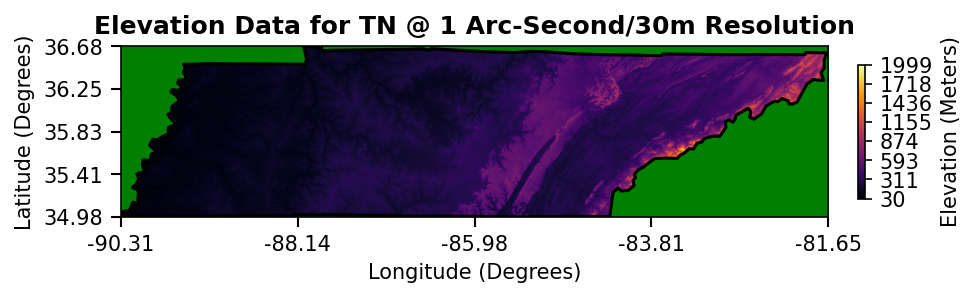

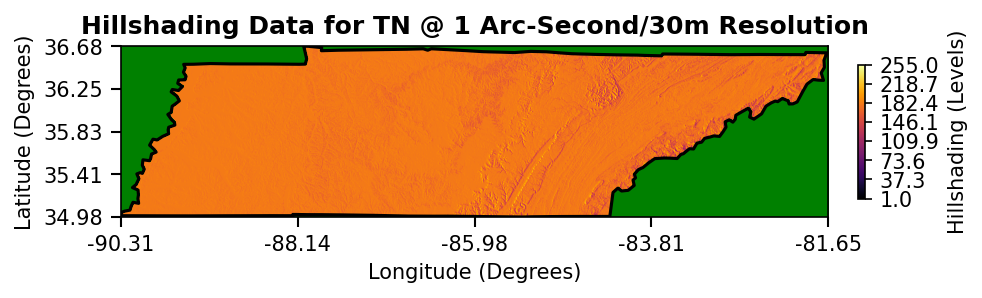

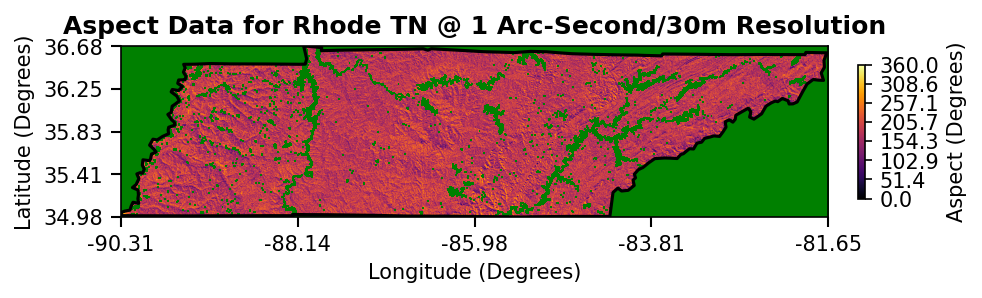

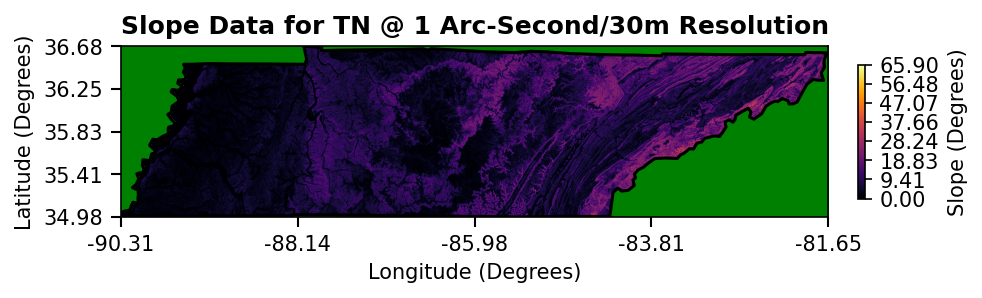

In [11]:
# File paths to the mosaics
hillshade = os.path.join(root_folder, 'hillshading.tif')
aspect = os.path.join(root_folder, 'aspect.tif')
slope = os.path.join(root_folder, 'slope.tif')

# Create plots for all terrain parameters
geotiled.generate_img(rep_mosaic, downsample=5, reproject_gcs=True, shp_files=shape_file, title="Elevation Data for TN @ 1 Arc-Second/30m Resolution",    zunit="Meter",  xyunit="Degree", ztype="Elevation",   crop_shp=True) 
geotiled.generate_img(hillshade,  downsample=5, reproject_gcs=True, shp_files=shape_file, title="Hillshading Data for TN @ 1 Arc-Second/30m Resolution",  zunit="Level",  xyunit="Degree", ztype="Hillshading", crop_shp=True)
geotiled.generate_img(aspect,     downsample=5, reproject_gcs=True, shp_files=shape_file, title="Aspect Data for Rhode TN @ 1 Arc-Second/30m Resolution", zunit="Degree", xyunit="Degree", ztype="Aspect",      crop_shp=True)
geotiled.generate_img(slope,      downsample=5, reproject_gcs=True, shp_files=shape_file, title="Slope Data for TN @ 1 Arc-Second/30m Resolution",        zunit="Degree", xyunit="Degree", ztype="Slope",       crop_shp=True)

## End of Demo